In [121]:
from kbmodpy import kbmod as kb
from trajectoryFiltering import *
import numpy as np
import random as rd
import math
import matplotlib.pyplot as plt
import os
%matplotlib inline

In [122]:
path = '../../HITS/test_9/2,5tempExp/new_header/' # found
#'../../HITS/test_29/4,2tempExp/new_header/' # masking issue
#'../../HITS/tract_5_5,3/' # no header
#'../../HITS/test_35/4,6tempExp/new_header/' # found (only 4 images)
#'../../HITS/test_27/3,5tempExp/new_header/' #found

In [123]:
files = os.listdir(path)

In [124]:
files.sort()
files = [path+f for f in files]
files = files[:10]
files

['../../HITS/test_9/2,5tempExp/new_header/v410903-fg.fits',
 '../../HITS/test_9/2,5tempExp/new_header/v410959-fg.fits',
 '../../HITS/test_9/2,5tempExp/new_header/v411009-fg.fits',
 '../../HITS/test_9/2,5tempExp/new_header/v411243-fg.fits',
 '../../HITS/test_9/2,5tempExp/new_header/v411293-fg.fits',
 '../../HITS/test_9/2,5tempExp/new_header/v411343-fg.fits',
 '../../HITS/test_9/2,5tempExp/new_header/v411393-fg.fits',
 '../../HITS/test_9/2,5tempExp/new_header/v411444-fg.fits',
 '../../HITS/test_9/2,5tempExp/new_header/v411645-fg.fits',
 '../../HITS/test_9/2,5tempExp/new_header/v411746-fg.fits']

In [125]:
images = [kb.layered_image(f) for f in files]

Object Generation Parameters

In [126]:
p = kb.psf(1.5)
object_count = 0#200
x_range = (5,3650)
y_range = (5, 3650)
angle_range = (0.1, 0.5)
velocity_range = (1900, 2900)
flux_range = (800, 4000)

Search Parameters

In [127]:
min_observations = 3
angle_steps = 120
velocity_steps = 100
search_margin = 1.2

In [128]:
print(angle_range[1]-angle_range[0])
print(velocity_range[1]-velocity_range[0])

0.4
1000


Generate Random trajectories within bounds

In [129]:
results_key = []
for _ in range(object_count):
    traj = kb.trajectory()
    traj.x = int(rd.uniform(*x_range))
    traj.y = int(rd.uniform(*y_range))
    ang = rd.uniform(*angle_range)
    vel = rd.uniform(*velocity_range)
    traj.x_v = vel*math.cos(ang)
    traj.y_v = vel*math.sin(ang)
    traj.flux = rd.uniform(*flux_range)
    results_key.append(traj)

Add a real object to the list of trajectories

In [130]:
if path == '../../HITS/test_35/4,6tempExp/new_header/':
    real_result = kb.trajectory()
    real_result.flux = 5300
    real_result.x = 3123
    real_result.y = 3043
    real_result.x_v = 2425
    real_result.y_v = 1050
    results_key.append(real_result)
results_key

[]

Test that clustering is not able to collapse together too many unique trajectories

In [131]:
#len(cluster_trajectories(results_key, dbscan_args=dict(eps=0.007, min_samples=1))[1])

Use the generated trajectories to add objects into the images

In [132]:
for t in results_key:
    add_trajectory(images, t, p)

Sanity check

In [133]:
len(match_trajectories(results_key, results_key, 0.01, 1)[0])

0

In [134]:
stack = kb.image_stack(images)

Mask out stars and bad pixels

In [135]:
flags = ~0 # mask pixels with any flags
flag_exceptions = [32,39] # unless it has one of these special combinations of flags
master_flags = int('100111', 2) # mask any pixels which have any of 
# these flags in more than two images

In [136]:
stack.apply_mask_flags(flags, flag_exceptions)

In [137]:
stack.apply_master_mask(master_flags, 2)

In [138]:
for _ in range(6):
    stack.grow_mask()

In [139]:
images = [i.science() for i in stack.get_images()]

Calculate masked percentage of an image to estimate probablilty of placing an object under a mask

In [140]:
img = images[1]
percent_masked = img[np.where(img==kb.no_data)].size/img.size
percent_masked

0.38933656462585037

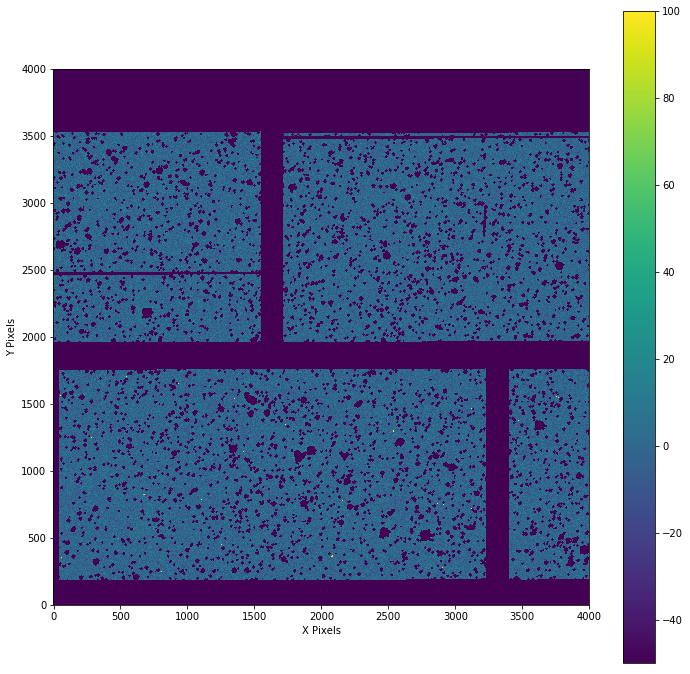

In [141]:
fig = plt.figure(figsize=(12,12))
plt.imshow(images[4] [0:4000,0:4000], origin='lower',  vmin=-50, vmax=100)#cmap=plt.cm.Greys_r,
plt.xlabel('X Pixels')
plt.ylabel('Y Pixels')
plt.colorbar()

In [142]:
search = kb.stack_search(stack, p)
search.psi_sigma_cutoff(1.6)
search.set_debug(True)

In [143]:
search_ang_r = (angle_range[0]/search_margin,
                angle_range[1]*search_margin)
search_vel_r = (velocity_range[0]/search_margin,
                velocity_range[1]*search_margin)
#search.gpu(angle_steps,velocity_steps, *angle_range, *velocity_range, min_observations)

In [144]:
#search.get_results(0,20)

In [145]:
#search.region_search(2400, 1040, 50, 255, 3)
#  xvel, yvel, radius, minLH, minimum observations
res = search.region_search(200, 80, 180, 8.5, 6)

In [146]:
print(len(res))
res

125


[ix: 2509.000000 iy: 544.000000 fx: 2992.000000 fy: 575.000000 depth: 0 obs_count: 7 lh: 13.409075 flux 225.793869,
 ix: 3656.000000 iy: 3350.000000 fx: 4077.000000 fy: 3496.000000 depth: 0 obs_count: 6 lh: 13.010097 flux 223.645706,
 ix: 1711.000000 iy: 943.000000 fx: 1970.000000 fy: 1155.000000 depth: 0 obs_count: 8 lh: 12.909639 flux 206.375153,
 ix: 2522.000000 iy: 544.000000 fx: 3010.000000 fy: 574.000000 depth: 0 obs_count: 8 lh: 12.782667 flux 201.757263,
 ix: 1785.000000 iy: 1093.000000 fx: 2017.000000 fy: 1260.000000 depth: 0 obs_count: 9 lh: 12.590473 flux 189.755966,
 ix: 1319.000000 iy: 1483.000000 fx: 1643.000000 fy: 1496.000000 depth: 0 obs_count: 7 lh: 12.823453 flux 217.660248,
 ix: 523.000000 iy: 2189.000000 fx: 843.000000 fy: 2245.000000 depth: 0 obs_count: 8 lh: 12.575700 flux 206.066528,
 ix: 2772.000000 iy: 474.000000 fx: 3175.000000 fy: 607.000000 depth: 0 obs_count: 8 lh: 12.315013 flux 193.189194,
 ix: 2531.000000 iy: 547.000000 fx: 3031.000000 fy: 570.000000 de

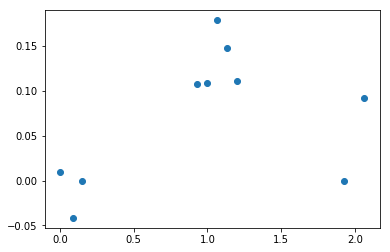

In [147]:
fig, ax = plt.subplots()
ax.plot(stack.get_times(), search.lightcurve(res[5])[0], 'o')
plt.show()

Starting at 0


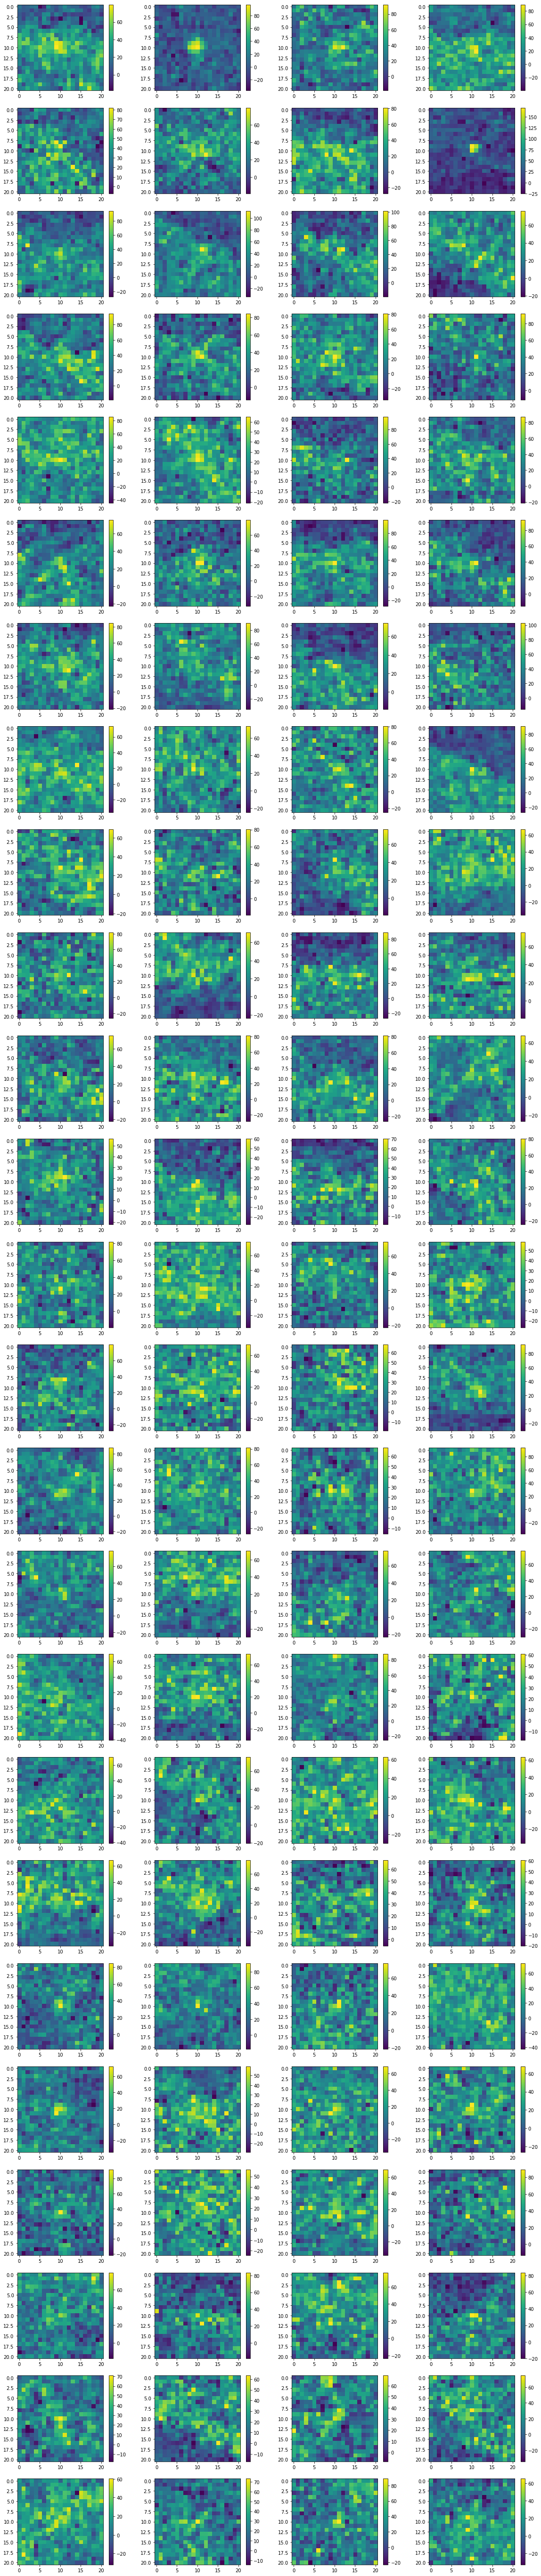

In [148]:
#stamps = search.sci_stamps(res[6], 10)
stamps = [search.stacked_sci(res[n], 10) for n in range(100)]
fig = plt.figure(figsize=(20, 100))
set_on = 1
plot_count = len(stamps)
print ('Starting at %i' % int((set_on - 1)*plot_count))
for i in range((set_on-1)*plot_count,set_on*plot_count):
    fig.add_subplot(25,4,i-(set_on-1)*plot_count+1)
    plt.imshow(stamps[i], #cmap=plt.cm.Greys_r, 
               interpolation=None)
    plt.colorbar()

Starting at 0


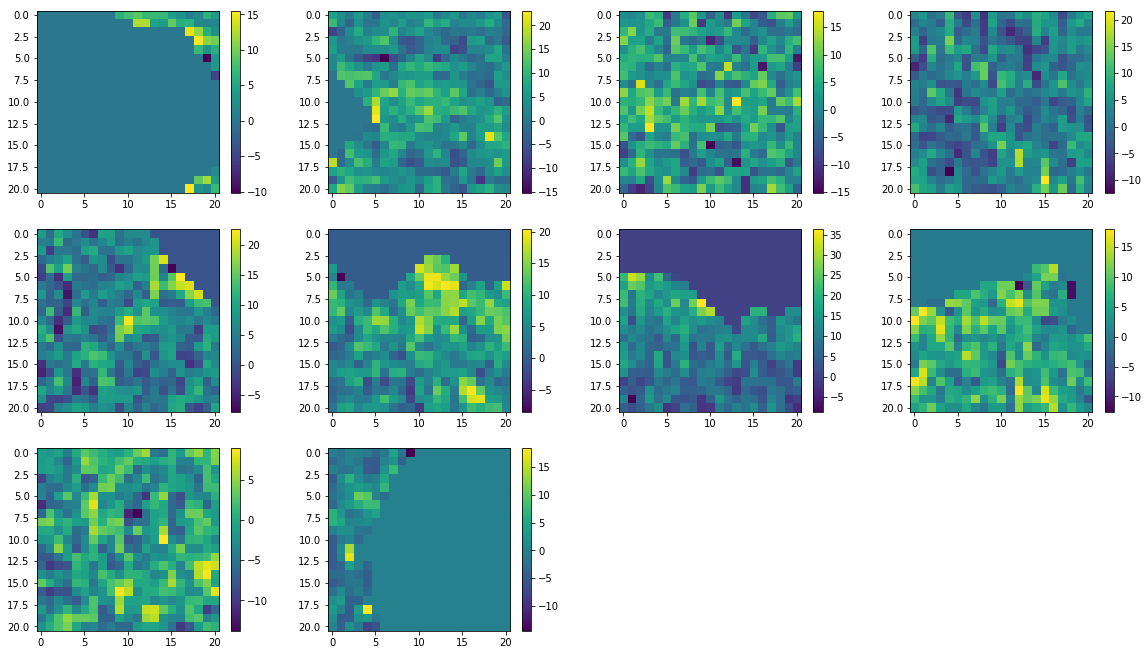

In [149]:
stamps = search.sci_stamps(res[0], 10)
fig = plt.figure(figsize=(20, 100))
set_on = 1
plot_count = len(stamps)
print ('Starting at %i' % int((set_on - 1)*plot_count))
for i in range((set_on-1)*plot_count,set_on*plot_count):
    fig.add_subplot(25,4,i-(set_on-1)*plot_count+1)
    plt.imshow(stamps[i], #cmap=plt.cm.Greys_r, 
               interpolation=None)
    plt.colorbar()

In [35]:
matched = []
for r in res:
    if any(abs(r.ix-t.x)<=1 and abs(r.iy-t.y)<=1 for t in results_key ):
        matched.append(r)
len(matched)

0

In [36]:
matched

[]

# Examining Pooling

In [28]:
pooled = search.get_psi_pooled()

In [52]:
pooled_imgs = [np.array(im, copy=False) for im in pooled[1]]

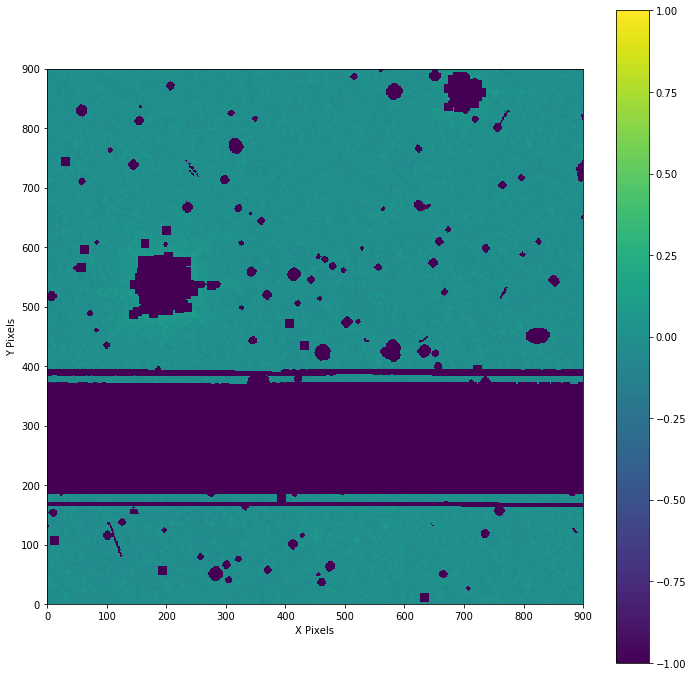

In [53]:
fig = plt.figure(figsize=(12,12))
plt.imshow(pooled_imgs[0] [2700:3600,2900:3800], origin='lower',  vmin=-1, vmax=1)#cmap=plt.cm.Greys_r,
plt.xlabel('X Pixels')
plt.ylabel('Y Pixels')
plt.colorbar()

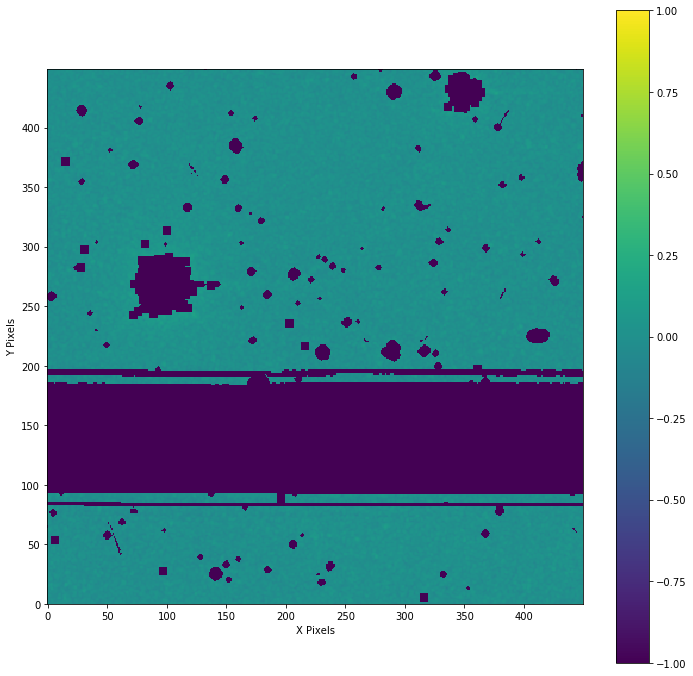

In [54]:
fig = plt.figure(figsize=(12,12))
plt.imshow(pooled_imgs[1] [1350:1800,1450:1900], origin='lower',  vmin=-1, vmax=1)#cmap=plt.cm.Greys_r,
plt.xlabel('X Pixels')
plt.ylabel('Y Pixels')
plt.colorbar()

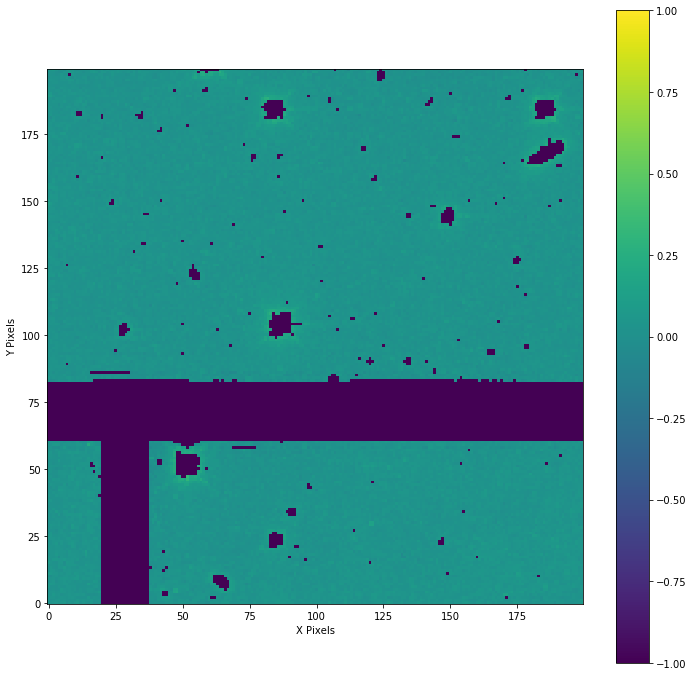

In [75]:
fig = plt.figure(figsize=(12,12))
plt.imshow(pooled_imgs[3] [300:500,300:500], origin='lower',  vmin=-1, vmax=1)#cmap=plt.cm.Greys_r,
plt.xlabel('X Pixels')
plt.ylabel('Y Pixels')
plt.colorbar()